In [9]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write


In [10]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.5.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.5.2 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.2


In [11]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

In [12]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [13]:
adata.var_names_make_unique
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


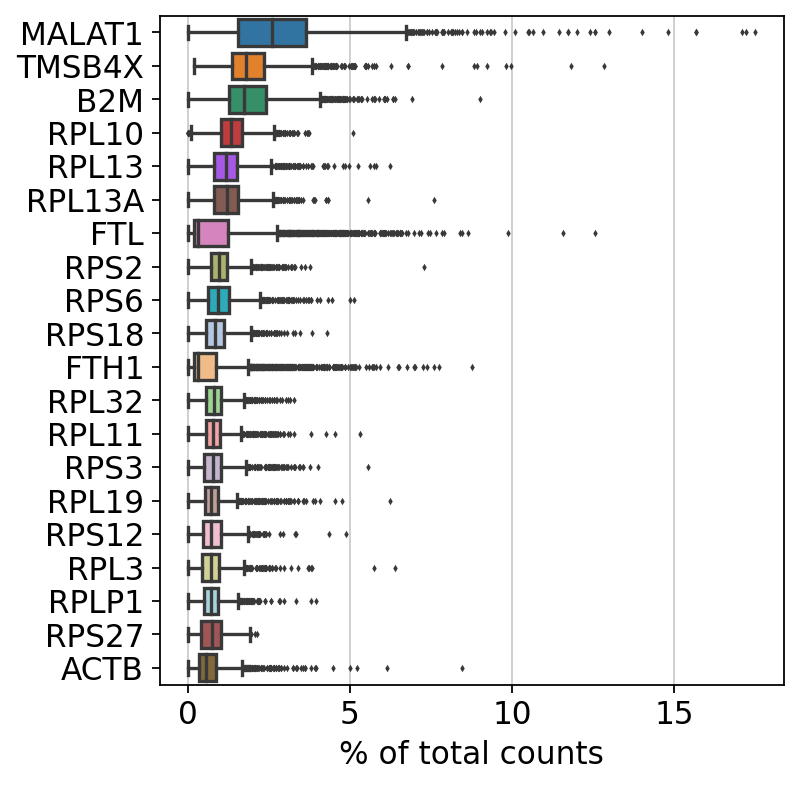

filtered out 19024 genes that are detected in less than 3 cells


In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [15]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/home/mwu/miniconda3/envs/stream/lib/python3.6/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [16]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


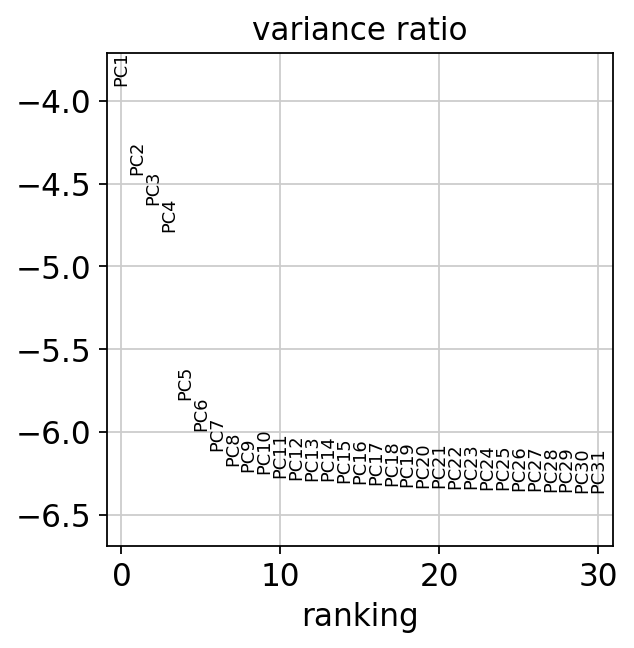

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


In [17]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


In [18]:
sc.tl.umap(adata)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


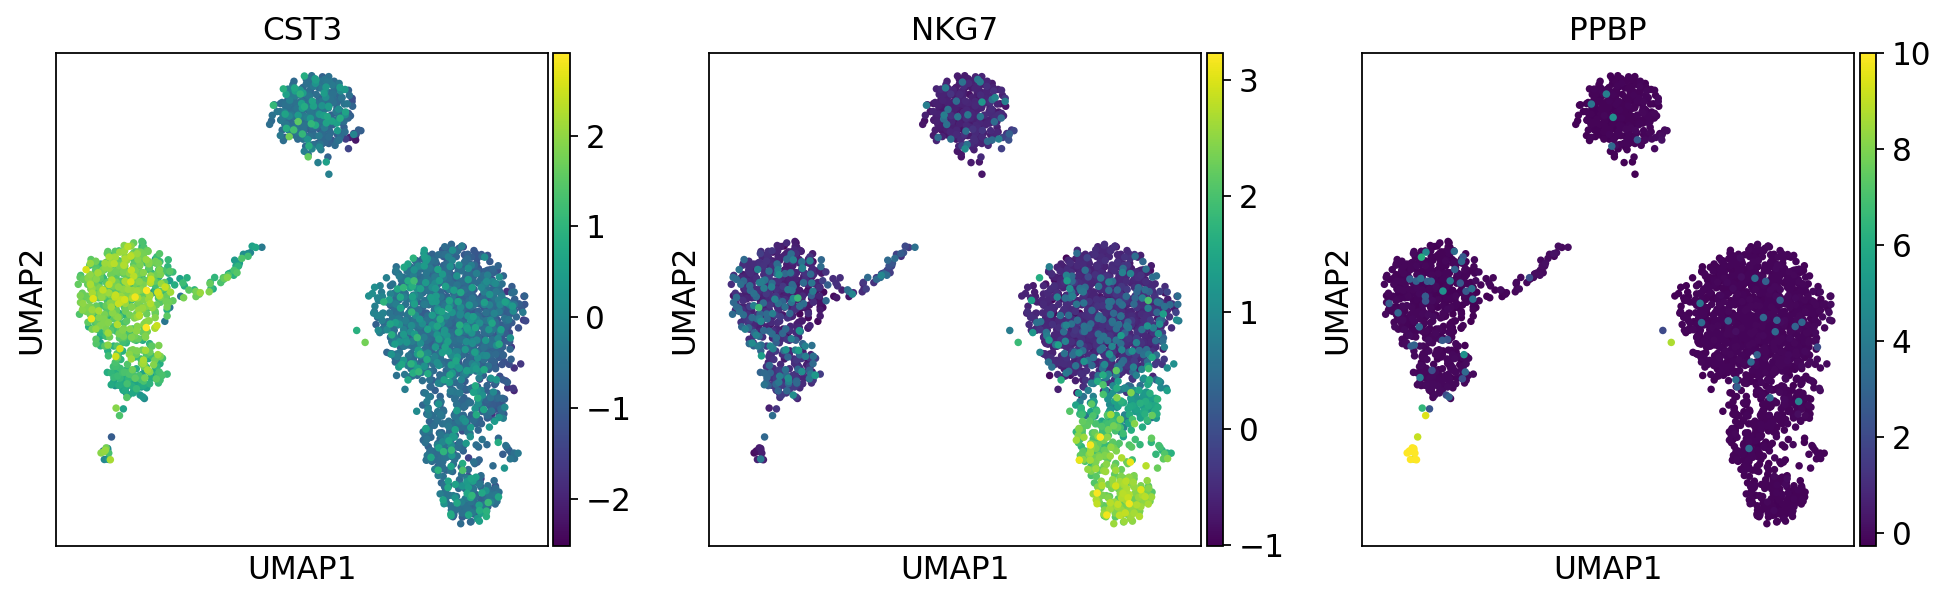

In [19]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


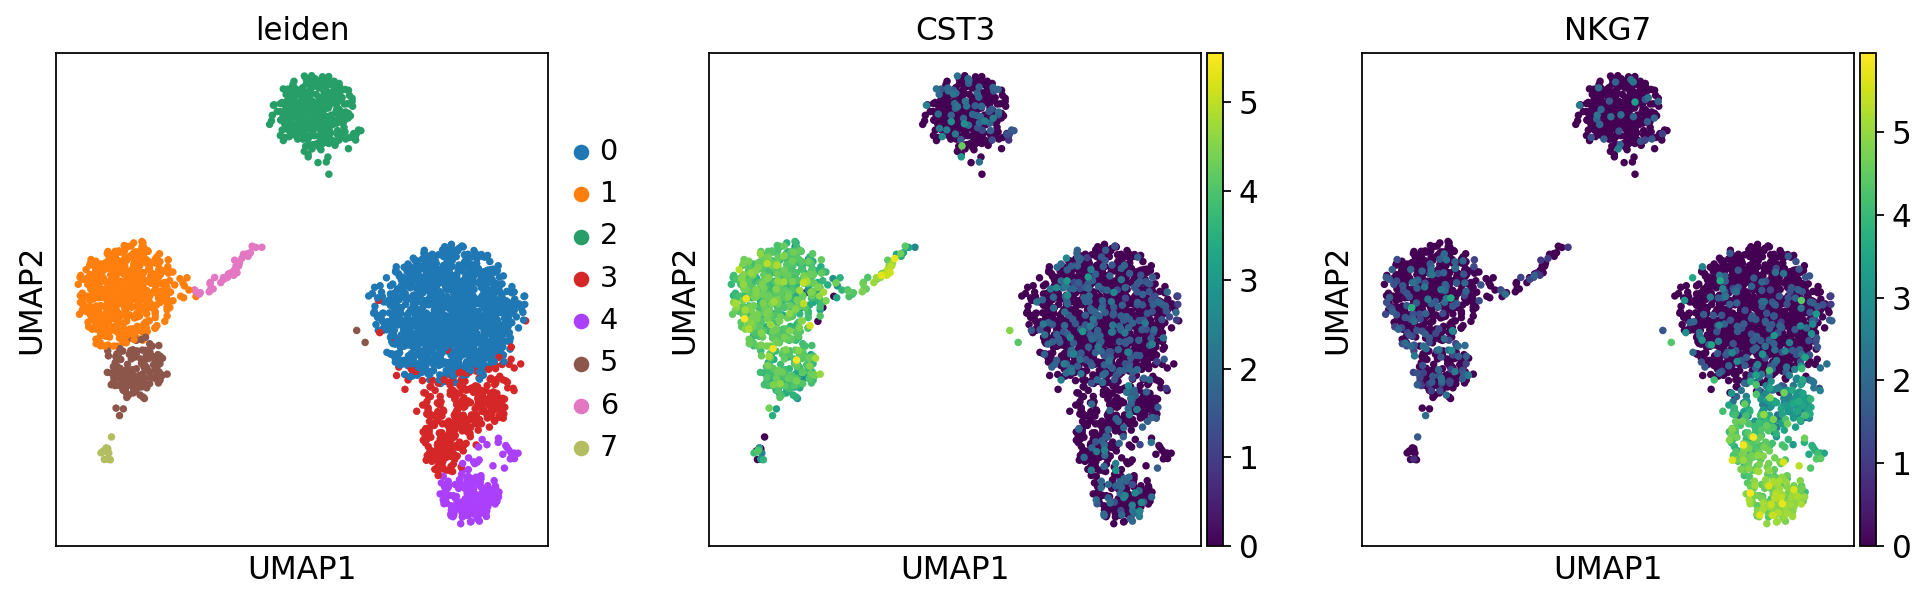

In [20]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


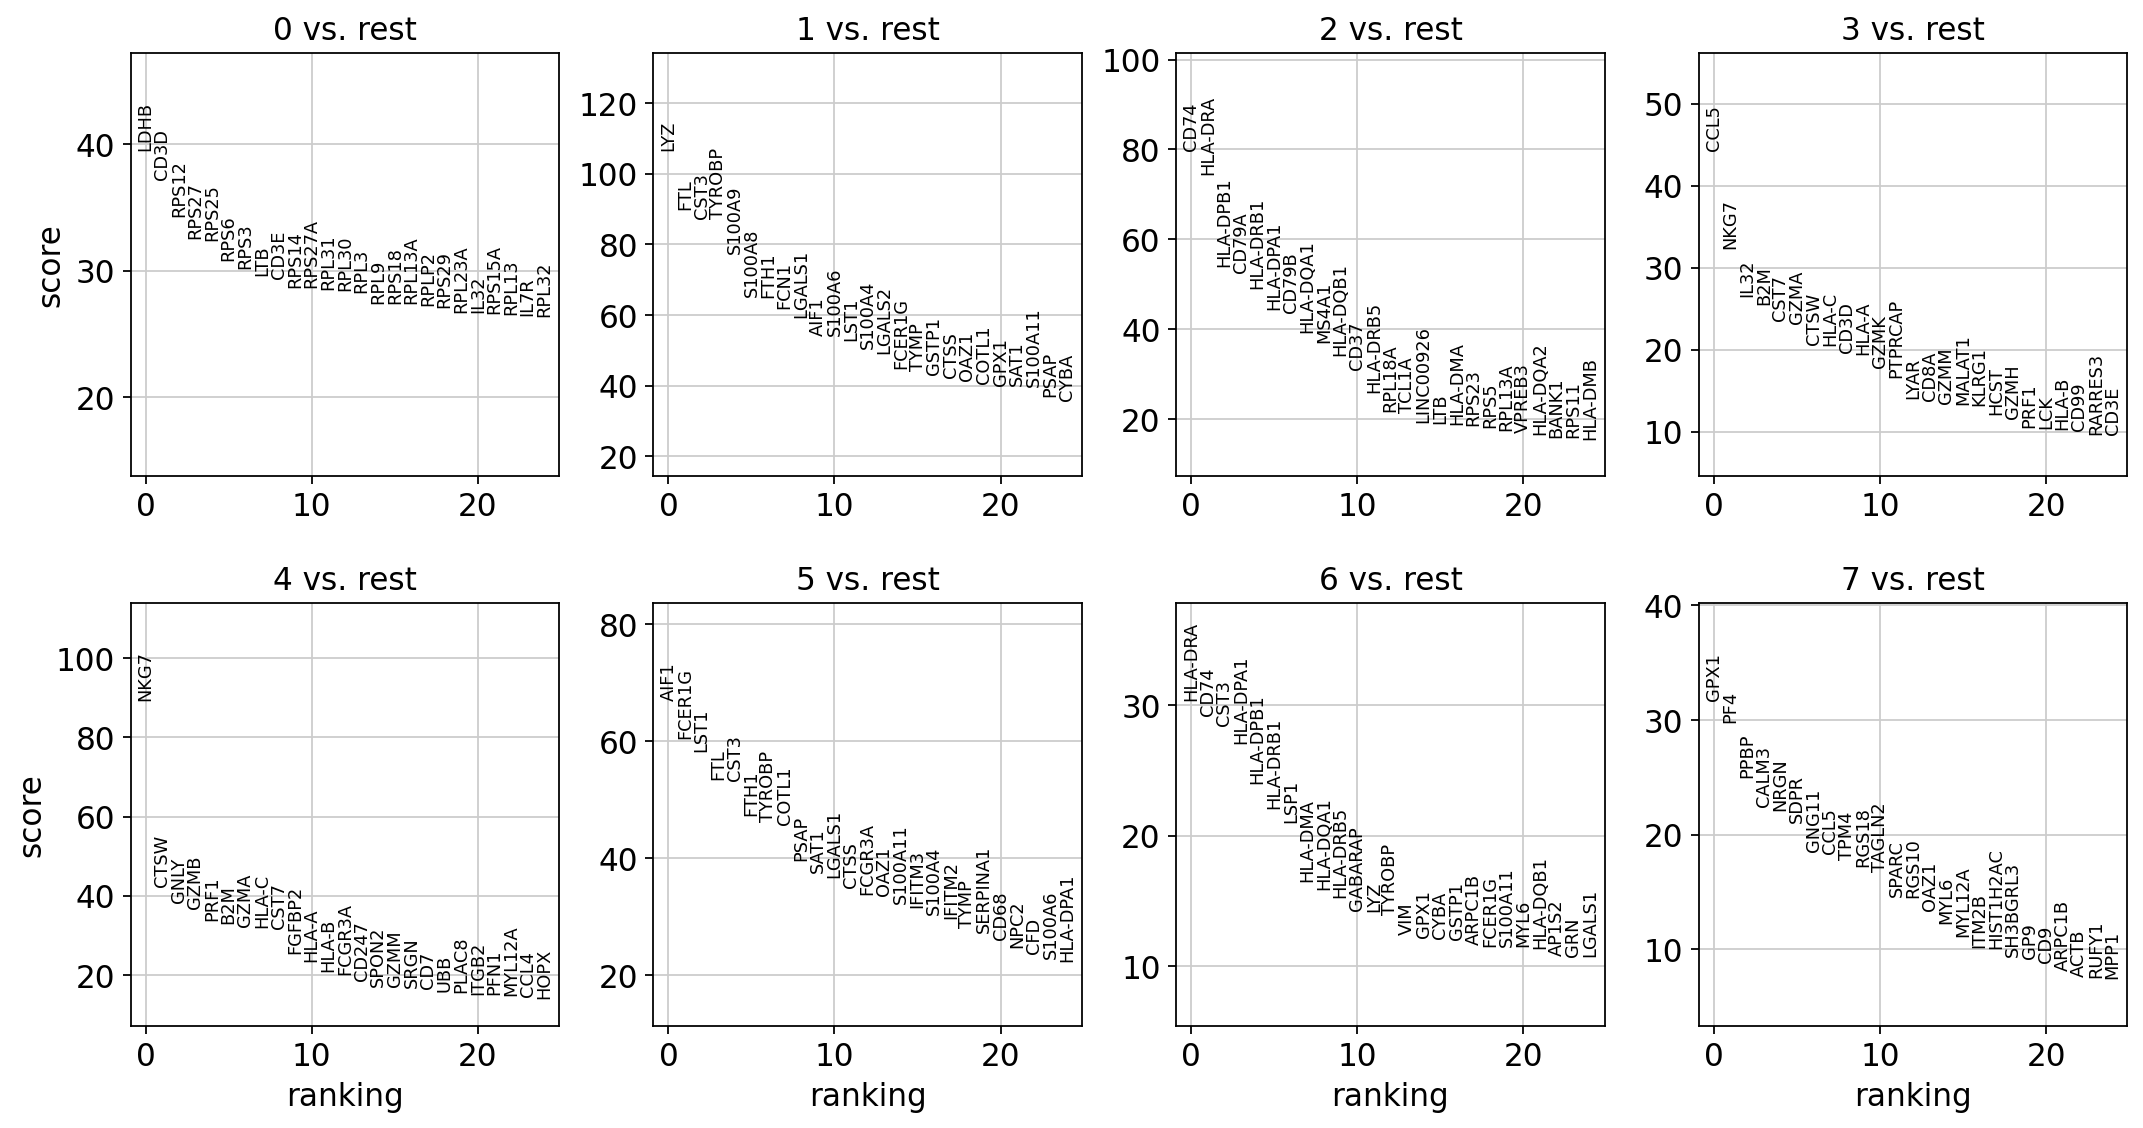

In [21]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [22]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1'
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7
0,LDHB,LYZ,CD74,CCL5,NKG7,AIF1,HLA-DRA,GPX1
1,CD3D,FTL,HLA-DRA,NKG7,CTSW,FCER1G,CD74,PF4
2,RPS12,CST3,HLA-DPB1,IL32,GNLY,LST1,CST3,PPBP
3,RPS27,TYROBP,CD79A,B2M,GZMB,FTL,HLA-DPA1,CALM3
4,RPS25,S100A9,HLA-DRB1,CST7,PRF1,CST3,HLA-DPB1,NRGN


In [23]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,LDHB,3.020665e-268,LYZ,0.0,CD74,0.000000e+00,CCL5,1.085869e-158,NKG7,4.611341e-236,AIF1,4.838756e-217,HLA-DRA,6.560267e-32,GPX1,1.326433e-13
1,CD3D,3.647077e-243,FTL,0.0,HLA-DRA,0.000000e+00,NKG7,3.517673e-112,CTSW,1.389718e-102,FCER1G,1.568297e-174,CD74,2.552722e-31,PF4,1.251720e-12
2,RPS12,1.934689e-208,CST3,0.0,HLA-DPB1,2.257058e-272,IL32,5.931103e-98,GNLY,3.994115e-85,LST1,2.695105e-149,CST3,2.601737e-29,PPBP,9.925949e-12
3,RPS27,1.822244e-191,TYROBP,0.0,CD79A,1.606497e-169,B2M,5.596337e-94,GZMB,3.393432e-82,FTL,7.940766e-176,HLA-DPA1,4.913538e-28,CALM3,1.688225e-11
4,RPS25,6.967709e-191,S100A9,0.0,HLA-DRB1,2.278961e-243,CST7,5.680602e-74,PRF1,2.718677e-77,CST3,1.054294e-188,HLA-DPB1,2.866572e-25,NRGN,4.092874e-11


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


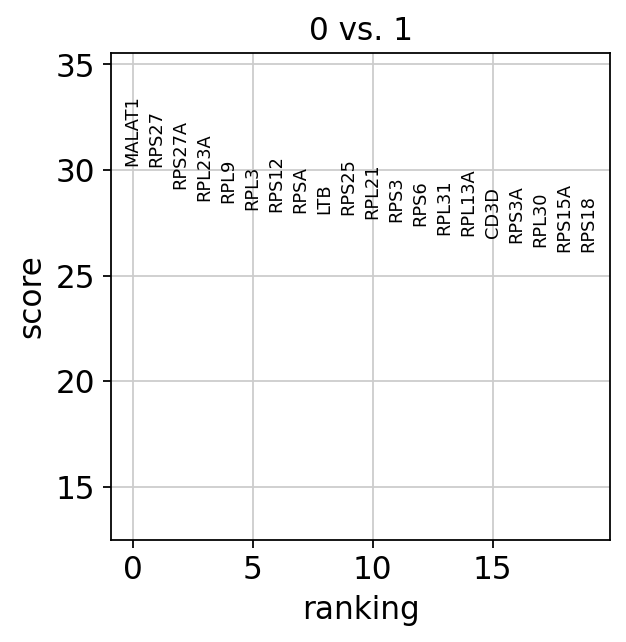

In [24]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)


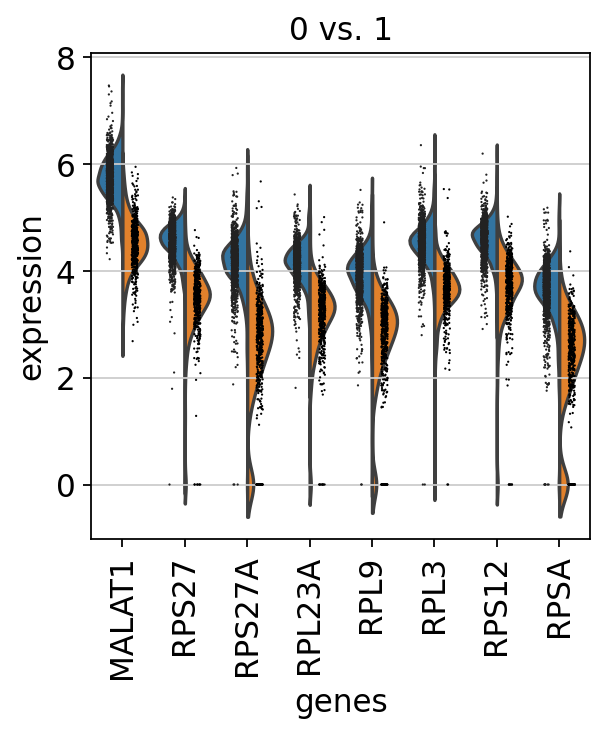

In [25]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

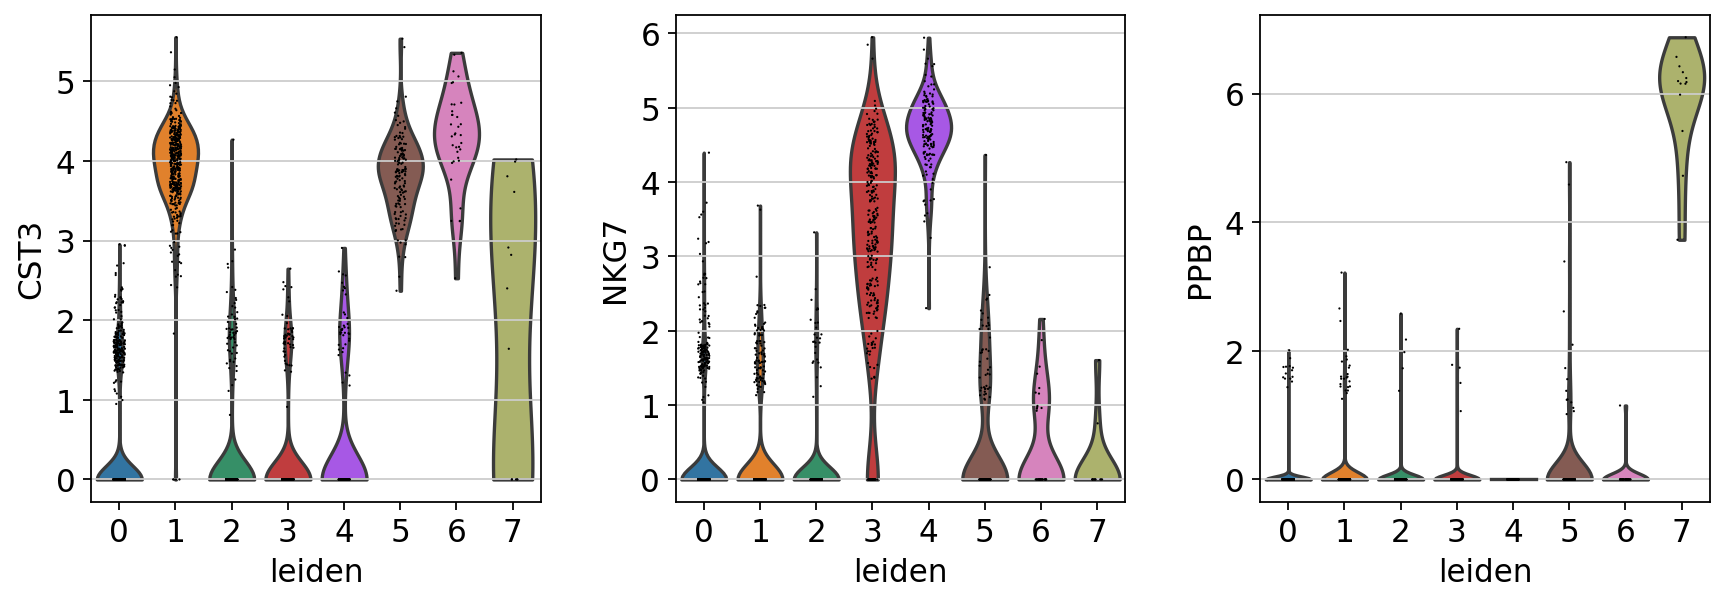

In [26]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [27]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.


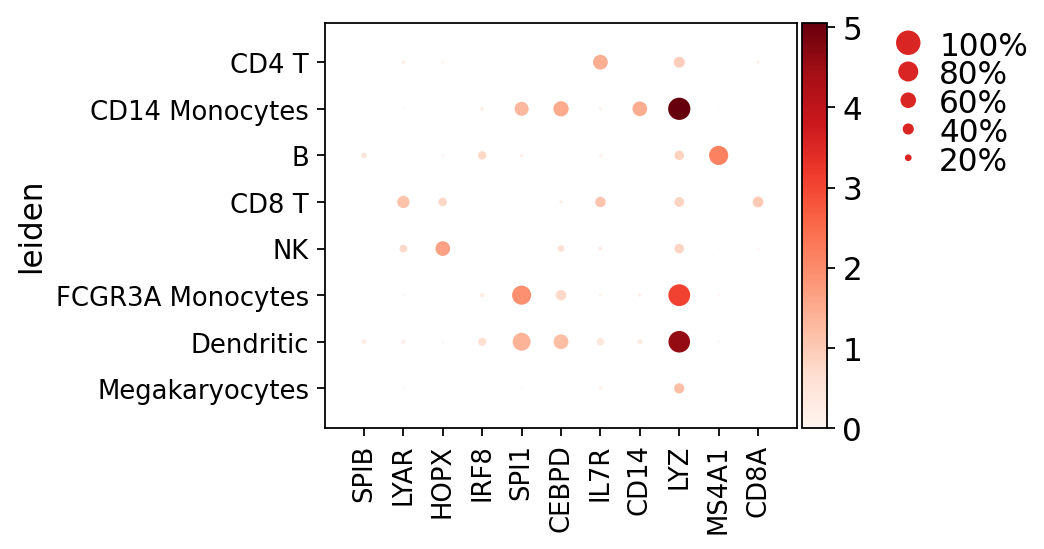

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[3.8499999999999996, 0, 0.2, 0.5, 0.25])

In [28]:
# sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')


In [ ]:
import pandas as pd
t=adata.X
pd.DataFrame(data=t, index=adata.obs_names, columns=adata.raw.var_names).to_csv('tutorial_data/pyscnet_scanpy_pbmc/pbmc_raw.csv')